In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class AlexNet(nn.Module):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(self.init_cnn)
        
    def init_cnn(self, layer):
        if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
            nn.init.xavier_uniform_(layer.weight)
            
    def forward(self, x):
        return self.net(x)

In [3]:
# Load CIFAR-10 dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# Initialize the model, loss function, and optimizer
net = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

D:\AI_Dev_Vault\Anaconda\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# Train the network
valid_losses = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    net.eval()

    total_valid_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()
        average_valid_loss = total_valid_loss / len(testloader)
        valid_losses.append(average_valid_loss)
    net.train()
        
    print('[%d] validation loss: %.3f' % (epoch + 1, average_valid_loss))
    total_valid_loss = 0.0
            
print('Finished Training')

[1,  2000] training loss: 1.275
[1,  4000] training loss: 1.219
[1,  6000] training loss: 1.121
[1,  8000] training loss: 1.099
[1, 10000] training loss: 1.032
[1, 12000] training loss: 0.986
[1] validation loss: 0.891
[2,  2000] training loss: 0.911
[2,  4000] training loss: 0.884
[2,  6000] training loss: 0.852
[2,  8000] training loss: 0.833
[2, 10000] training loss: 0.813
[2, 12000] training loss: 0.796
[2] validation loss: 0.767
[3,  2000] training loss: 0.681
[3,  4000] training loss: 0.713
[3,  6000] training loss: 0.683
[3,  8000] training loss: 0.673
[3, 10000] training loss: 0.682
[3, 12000] training loss: 0.670
[3] validation loss: 0.719
[4,  2000] training loss: 0.520
[4,  4000] training loss: 0.573
[4,  6000] training loss: 0.570
[4,  8000] training loss: 0.575
[4, 10000] training loss: 0.586
[4, 12000] training loss: 0.565
[4] validation loss: 0.705
[5,  2000] training loss: 0.445
[5,  4000] training loss: 0.444
[5,  6000] training loss: 0.462
[5,  8000] training loss: 0.

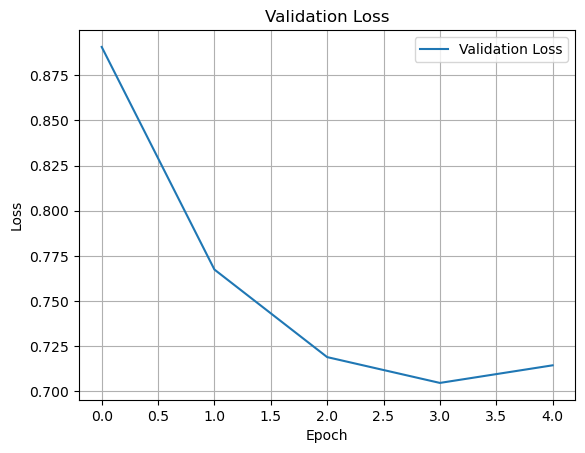

In [21]:
# Plotting
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Saving the weights
PATH = "AlexNet_Weights.pth"
torch.save(net.state_dict(), PATH)

In [23]:
#Loading the weights
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
# Num. of params
total_params = 0

# Iterate over the model's parameters
for param in net.parameters():
    total_params += param.numel()

print("Total number of parameters in the model:", total_params)


Total number of parameters in the model: 46787978
